#### Импорт необходимых библиотек

In [1]:
# Импорт необходимых библиотек для дальнейшей работы
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from collections.abc import Mapping, Sequence
from itertools import chain
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from pathlib import Path
from regex import Pattern, compile as re_compile
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder
from spacy import load as spacy_load_model
from spacy.cli import download as spacy_download_model
from typing import Any

# Инициализация дополнительных опций и настроек
pd.set_option('display.max_columns', 250)
# nltk.download('punkt_tab')
warnings.filterwarnings('ignore')

<hr>
<br>

## Стемминг и Лематизация


- **Стемминг** — процесс нахождения основы для заданного слова, т.е. приведения слова к некоторой базовой форме так, что все различные варианты этого слова могут быть представлены одним и тем же словом (путем удаления окончаний и суффиксов). Например:

    `шапки, шапку, шапок → шапка`

    Стемминг помогает уменьшить сложность текста и улучшить производительность алгоритмов анализа.


- **Лемматизация** — это процесс сопоставления всех различных форм слова с его основой или леммой. Хотя это определение кажется близким к определению стемминга, на самом деле они отличаются. Например:
  
    `позитивные → позитивный`

    В отличие от стемминга, лемматизация сводит слова к их лемме — это более сложный процесс, который учитывает морфологический анализ слов. Лемматизация более точно обрабатывает слова, приводя их к словарной форме.

<hr>

#### Функция для загрузки моделей spaCy

Для обработки текста с помощью библиотеки `spaCy` нужно загрузить натренированную модель. Перечень поддерживаемых языков и наличие моделей можно посмотреть [документации](https://spacy.io/usage/models#languages).

In [2]:
def spacy_model(model_name: str):
    """Функция скачивает указанную языковую модель."""

    try:
        return spacy_load_model(model_name)
    except OSError:
        spacy_download_model(model_name)
        return spacy_load_model(model_name)

Загрузим среднего размера модели для английского и русского языков:
- [en_core_web_md](https://spacy.io/models/en#en_core_web_md) 31Mb
- [ru_core_news_md](https://spacy.io/models/ru#ru_core_news_md) 39Mb

In [3]:
en_spacy_model = spacy_model('en_core_web_md')
ru_spacy_model = spacy_model('ru_core_news_md')

<hr>

#### Кастомный токенизатор для токенизации русских текстов для BoW

Для более качественного векторного представления текста с помощью `Bag of Words` определим свой собственных токенизатор, который будет возвращать леммы слов. Приведение слова к его основной форме (лемме) позволит уменьшить размерность векторов.

Токенизатор будет поддерживать следующий функционал:
- удаление цифр (опция `remove_numbers`, с возможностью отключения) — номера телефонов, года и т.п.;
- удаление знаков пунктуации (опция `remove_punctuation`, с возможностью отключения) — знаки препинания будут являтся шумом в векторной модели;
- удаление прочих символов (опция `remove_symbols`, с возможностью отключения) — смайлики, математические операторы и пр.;
- удаление лишних пробелов (опция `normalize_whitespaces`, с возможностью отключения);
- удаление стоп-слов (опция `keep_stopwords`, с возможностью отключения); стоп-слова — это общеупотребительные слова в языке, которые обычно несут мало смысловой нагрузки (например, "и", "в", "на").

In [4]:
class RussianTokenizer:
    """RussianTokenizer.

    Класс для токенизации русских текстов с помощью
    spaCy. На вход принимается строка, на выходе список
    из лемм.
    """

    def __init__(
        self,
        remove_numbers: bool = True,
        remove_punctuation: bool = True,
        remove_symbols: bool = True,
        normalize_whitespaces: bool = True,
        keep_stopwords: bool = False,
    ):
        if remove_numbers:
            self._remove_numbers = re_compile(r'\p{Number}')
        if remove_punctuation:
            self._remove_punctuation = re_compile(r'\p{Punctuation}')
        if remove_symbols:
            self._remove_symbols = re_compile(r'\p{Symbol}')
        if normalize_whitespaces:
            self._normalize_whitespaces = re_compile(r'\s+')

        self._keep_stopwords = keep_stopwords
        self._activated_patterns = tuple(
            (attr, value) for attr, value in self.__dict__.items() if isinstance(value, Pattern)
        )

    def __call__(
        self,
        text_line: str,
        *args: Sequence[Any],
        **kwargs: Mapping[str, Any],
        ) -> Sequence[str]:

        if self._activated_patterns:
            for attr, regex_pattern in self._activated_patterns:
                if attr == '_normalize_whitespaces':
                    text_line = regex_pattern.sub(' ', text_line).strip()
                else:
                    text_line = regex_pattern.sub('', text_line).strip()

        tokenized_doc = ru_spacy_model(text_line)
        if self._keep_stopwords:
            return list(token.lemma_ for token in tokenized_doc if token.lemma_)
        return list(token.lemma_ for token in tokenized_doc if token.lemma_ and not token.is_stop)

ru_tokenizer = RussianTokenizer()

<hr>
<br>

### Стемминг с помощью `NLTK`

Для стемминга токенов на английском языке используется [PorterStemmer](https://www.nltk.org/api/nltk.stem.snowball.html#nltk.stem.snowball.PorterStemmer). По сравнению с другими алгоритмами стемминга он дает наилучший результат и имеет меньший процент ошибок.

In [5]:
remove_punctuation = re_compile(r'\p{Punctuation}')
stemmer = PorterStemmer()
en_text = '"Walking in the woods is pleasant!" - he said happily!'
en_text_no_punct = remove_punctuation.sub('', en_text)
en_tokens = word_tokenize(en_text_no_punct)
en_stemmed_tokens = [stemmer.stem(token) for token in en_tokens]

en_stemming = pd.DataFrame.from_dict(
    data={
        'token': en_tokens,
        'stemmed token': en_stemmed_tokens
    }
)
en_stemming

,token,stemmed token
0,Walking,walk
1,in,in
2,the,the
3,woods,wood
4,is,is
5,pleasant,pleasant
6,he,he
7,said,said
8,happily,happili


**Стемминг на русском языке.**

Для стемминга токенов на других языках используется [Snowball Stemmer](https://www.nltk.org/api/nltk.stem.snowball.html#nltk.stem.snowball.SnowballStemmer). Snowball Stemmer, по сравнению с Porter Stemmer, является мультиязычным. Он поддерживает различные языки и основан на языке программирования Snowball, известном своей эффективностью при обработке небольших строк.

In [6]:
ru_stemmer = SnowballStemmer('russian')
ru_text = 'Съешь еще этих мягких французских булок да выпей чаю.'
ru_text_no_punct = remove_punctuation.sub('', ru_text)
ru_tokens = word_tokenize(ru_text_no_punct)
ru_stemmed_tokens = [ru_stemmer.stem(token) for token in ru_tokens]

ru_stemming = pd.DataFrame.from_dict(
    data={
        'token': ru_tokens,
        'stemmed token': ru_stemmed_tokens
    }
)
ru_stemming

,token,stemmed token
0,Съешь,съеш
1,еще,ещ
2,этих,эт
3,мягких,мягк
4,французских,французск
5,булок,булок
6,да,да
7,выпей,вып
8,чаю,ча


<hr>

### Лемматизация с помощью `spaCy`

<div class="alert alert-info">

Полный перечень атрибутов токена в токенизированном тексте можно посмотреть в [документации](https://spacy.io/api/token#attributes).

In [7]:
# Для английского предложения
en_doc = en_spacy_model('"Walking in the woods is pleasant!" - he said happily!')
en_tokens = [token for token in en_doc if not token.is_punct]

en_lemmatization = pd.DataFrame.from_dict(
    data={
        'token': en_tokens,
        'lemma': [token.lemma_ for token in en_tokens]
    }
)
en_lemmatization

,token,lemma
0,Walking,walk
1,in,in
2,the,the
3,woods,wood
4,is,be
5,pleasant,pleasant
6,he,he
7,said,say
8,happily,happily


<hr>

In [8]:
# Для русского предложения
ru_doc = ru_spacy_model('Съешь еще этих мягких французских булок да выпей чаю.')
ru_tokens = [token for token in ru_doc if not token.is_punct]

ru_lemmatization = pd.DataFrame.from_dict(
    data={
        'token': ru_tokens,
        'lemma': [token.lemma_ for token in ru_tokens]
    }
)
ru_lemmatization

,token,lemma
0,Съешь,съешь
1,еще,ещё
2,этих,этот
3,мягких,мягкий
4,французских,французский
5,булок,булка
6,да,да
7,выпей,выпей
8,чаю,чай


<div class="alert alert-info">

`spaCy` не предоставляет функционал для стемминга, поскольку стемминг неточен. `spaCy` предназначен в основном для использования в продакшене и неточности источник ошибок в продакшн системах. Лемматизация выполняет ту же работу, но более точно с помощью словаря, специфичного для языка, и возвращает точный корень слова.

<hr>
<br>

## One-Hot Encoding

Каждому слову `w` в словаре корпуса присваивается уникальный целочисленный идентификатор  `id`, который находится в диапазоне от 1 до `V`, где V — словарь уникальных слов, полученный из корпуса. Затем каждое слово представляется двоичным вектором V-мерности из нулей и единиц.

In [9]:
sentences = [
    'We need a new truck.',
    'We painted the house green.',
    'We turned on the radio.',
    'Did you play tennis yesterday?'
]

# Создаем перечень уникальных слов (токенов)
text_to_docs = map(lambda line: en_spacy_model(line), sentences)
tokenized_sents = [[token.lemma_ for token in doc if not token.is_punct] for doc in text_to_docs]
unique_tokens = sorted(set(chain.from_iterable(tokenized_sents)))

# Каждому токену в словаре присваиваем индекс и формируем словарь
vocabulary = {token: idx for idx, token in enumerate(unique_tokens, 1)}
print(f'Vocubulary:\n{vocabulary}\n')

# Создаем числовое представления текста для One-Hot энкодера
numerical_data = [[vocabulary[word] for word in doc] for doc in tokenized_sents]

# Векторизация с помощью One-Hot энкодера
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_text = one_hot_encoder.fit_transform(numerical_data)
print('One-Hot Encoded Representation:')
for encoded_line, tokenized_line in zip(encoded_text, tokenized_sents):
    print(f'{encoded_line} | {tokenized_line}')

Vocubulary:
{'a': 1, 'do': 2, 'green': 3, 'house': 4, 'need': 5, 'new': 6, 'on': 7, 'paint': 8, 'play': 9, 'radio': 10, 'tennis': 11, 'the': 12, 'truck': 13, 'turn': 14, 'we': 15, 'yesterday': 16, 'you': 17}

One-Hot Encoded Representation:
[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.] | ['we', 'need', 'a', 'new', 'truck']
[0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.] | ['we', 'paint', 'the', 'house', 'green']
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.] | ['we', 'turn', 'on', 'the', 'radio']
[1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1.] | ['do', 'you', 'play', 'tennis', 'yesterday']


### Недостатки:
- pазмер one-hot вектора прямо пропорционален размеру словаря, и у больших корпусов будут формироваться большие словари. Это приводит к разреженному представлению текста, где большинство записей в векторах являются нулями, что делает его вычислительно неэффективным для хранения, вычисления и обучения (разреженность приводит к переобучению);
- проблема слов не входящих в словарь OOV (out of vocabulary).

<hr>
<br>

## BoW (Bag of Words)

Основная идея заключается в том, чтобы представить рассматриваемый текст в виде мешка (набора) слов, игнорируя порядок и контекст. Основное предположение — текст, принадлежащий к определенному классу характеризуется уникальным набором слов. Если два текста содержат почти одинаковые слова, значит, они принадлежат к одному и тому же классу. Таким образом, анализируя слова, присутствующие в фрагменте текста, можно определить, к какому классу (мешку) он принадлежит.

Реалзиация `BoW` c помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#countvectorizer) из библиотеки `Scikit-learn`

Основные параметры класса `sklearn.feature_extraction.text.CountVectorizer`:
- `input`:
    - `filename` — список файлов которые нужно считать
    - `file` — путь к файлу который нужно считать
    - `content` — последовательность строк или байт
    - **default**=`content`
- `lowercasebool` — приведение к нижнему регистру текста перед токенизацей **default**=`True`
- `tokenizer` — вызываемый объект; использутся для токенизации текста; **default**=`None`
- `max_features` — словарь будет ограничен количеством токенов, указанным в `max_features`; при этом будут учитываться только наиболее встречающиеся, упорядоченные по частоте в корпусе токены. Если параметр не задан, то словарь строится из всех токенов; **default**=`None`

In [10]:
# Проинициализируем векторизатор 
bow_vectorizer = CountVectorizer(
    lowercase=False,
    tokenizer=ru_tokenizer,
    analyzer='word',
    binary=False,
)

In [11]:
corpus = [
    'Яркой визитной карточкой сиамских кошек является их характерный окрас 😋',
    'Мейн-куны одни из самых крупных кошек, их вес может достигать 12 кг!',
    'По характеру сококе подвижные, задорные, любопытные и умные кошки.',
    'Животные средние по своим размерам, вес тела достигает 3-5 кг.',
    'хорошо развитое мускулистое тело среднего размера, вес от 2-х до 4-х килограмм',
]

# Трансформируем строки в мешок слов
bow = bow_vectorizer.fit_transform(corpus)
bow_df = pd.DataFrame(
    data=bow.toarray(),
    columns=bow_vectorizer.get_feature_names_out()
)
bow_df

,вес,визитный,достигать,животное,задорный,карточка,кг,килограмм,кошка,крупный,любопытный,мейнкуны,мускулистый,окрас,подвижный,развитой,размер,сиамский,сококе,средний,тело,умный,характер,характерный,являться,яркий
0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,1
1,1,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0
3,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0
4,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0


<br>

Посмотрим на частоты слов из нашего "мешка слов". Отобразим первые 10 слов в порядке убывания по частоте встречаемости в корпусе.

In [12]:
bow_df.sum(axis=0).to_frame(name='frequency').sort_values('frequency', ascending=False).head(10)

,frequency
вес,3
кошка,3
кг,2
достигать,2
средний,2
размер,2
тело,2
карточка,1
визитный,1
животное,1


Из полученных частот видно, что слово «вес» встречается в корпусе 3 раза, в строках 2, 4 и 5. А слово «кошка» в строках 1, 2 и 3.

Сформируем «мешок слов» для текстовых файлов, в директории `./data`:

In [13]:
# Сформируем путь к файлам и отсортируем список файлов по имени
data_dir = Path('data').resolve()
doc_files = sorted(data_dir.glob('*_doc*'), key=lambda file: int(file.name.split('_')[0]))

# Проинициализируем векторизатор с аргументом `filename` для считывания файлов 
docs_bow_vectorizer = CountVectorizer(
    input='filename',
    lowercase=True,
    tokenizer=ru_tokenizer,
    analyzer='word',
    binary=False,
    max_features=500,
)
# Трансформируем документы в мешок слов
docs_bow = docs_bow_vectorizer.fit_transform(list(data_dir.glob('*_doc*')))
docs_bow_df = pd.DataFrame(
    data=docs_bow.toarray(),
    columns=docs_bow_vectorizer.get_feature_names_out()
)
docs_bow_df

,canis,cat,catus,d,domesticus,familiaris,fel,felis,litoria,lupus,lybica,rana,silvestris,абиссинский,ав,австралийский,адаптация,адаптировать,азия,активность,активный,аллерген,аллергик,аллергический,аллергия,алтайский,америка,американский,анализ,анатолия,англ,ареал,археолог,археологический,африка,африканский,белок,бесхвостый,биолог,биологический,ближневосточный,ближний,близкий,богатый,больший,большинство,большой,брачный,варьировать,варьироваться,вероятно,вероятный,вертикальный,верхний,вес,вещество,взрослый,вид,включать,влажный,вместе,вода,водный,водоём,возраст,волк,волна,восток,восточный,время,встречаться,вывод,высокий,высоко,высота,выявить,генетический,геном,германия,гибрид,гипоаллергенная,глаз,год,головастик,грудина,грудной,группа,грызун,густой,давать,дата,датироваться,дать,два,движение,дерево,детёныш,диета,дикий,длина,длинный,днк,добыча,доисторический,дом,домашний,дополнительный,достаточно,достигать,доступ,древесный,древний,дыхательный,европа,египет,египтянин,еда,единственный,единый,естественный,жаба,железа,железами,жермонпре,жертва,...,седалищный,семейство,семья,сибирский,сибирь,сибиряк,сигнал,сильно,сильный,симптом,сирия,система,ситуация,сказать,скелет,скорость,слизь,слово,сложный,служить,случай,см,смысл,соба́ка,собака,событие,совместный,современный,согласно,содержание,соединить,солоноватый,соответствующий,составлять,состояние,состоять,сосуществование,сотрудник,социальный,специальный,специфический,спинной,способ,способность,способный,сравнение,среда,средний,стадия,становиться,старый,статья,степной,стоить,столкновение,стоянка,страна,строение,суметь,сухой,суша,существовать,считать,считаться,счёт,таксон,тело,температура,теория,термин,территория,тест,течение,тикингом,типичный,ткань,точка,три,тропический,туловище,туловищный,тыс,тысяча,уборка,угроза,удобный,указывать,улучшить,университет,условие,установить,учёный,факт,характер,характерный,хвост,хвостовой,хищник,хищный,ход,хозяин,хозяйство,холодный,цвет,центральный,частота,часть,человек,человеческий,челюсть,череп,число,шаг,шакал,шведский,шейный,шерсть,широкий,шёрстный,щенок,эфиопия,юговосточной,являться,язык,яркий
0,0,0,0,8,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,2,5,4,3,12,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,1,2,0,1,2,0,0,0,2,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,3,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,4,0,0,0,2,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,...,0,1,1,8,0,2,0,0,0,6,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,2,0,1,3,0,0,0,0,2,0,0,0,0,2,1,0,0,0,0,0,1,0,0,0,0,2,0,2,2,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,2,1,0,0,2,0,2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2,0,4,0,0,0,0,0,0,0,0,7,0,1,0,0,0,0,0,1
1,0,1,7,0,3,0,0,19,0,0,2,0,9,0,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,2,1,0,0,2,3,0,0,0,0,2,2,4,1,0,2,2,1,0,1,0,1,0,1,1,5,0,2,5,0,0,2,0,0,1,0,3,3,4,0,7,3,0,2,1,0,0,4,0,0,0,0,0,14,0,1,7,9,6,0,1,0,1,1,4,2,0,1,0,13,4,1,3,2,0,0,21,0,1,4,0,0,5,1,4,2,2,0,0,0,0,0,0,0,0,2,...,0,1,0,1,0,0,1,0,2,0,1,2,0,0,4,2,0,7,0,0,2,4,0,0,6,0,1,2,2,0,2,0,1,4,0,5,2,0,1,0,1,2,0,3,5,1,1,3,0,2,0,1,3,0,0,0,0,0,1,0,0,0,4,1,0,2,5,3,0,0,2,0,0,0,1,1,2,2,0,0,0,2,4,0,0,1,0,0,0,2,3,7,3,0,1,2,1,5,1,1,1,2,0,0,1,2,1,16,2,3,5,2,0,0,0,1,1,1,1,0,0,0,11,10,0
2,4,0,0,0,0,4,0,0,0,2,0,0,0,0,0,1,0,0,5,0,0,0,0,0,0,2,3,3,5,0,1,0,2,3,0,0,0,0,4,1,0,2,2,0,0,0,2,0,0,2,1,2,0,2,0,0,0,2,0,0,0,0,0,0,5,19,0,3,2,5,2,3,0,1,1,2,5,2,2,0,0,0,23,0,0,0,5,0,0,0,3,1,1,2,0,0,1,2,0,0,0,3,0,4,0,10,0,0,0,0,0,6,0,2,0,0,0,1,1,0,0,0,0,2,0,...,0,1,0,0,2,0,0,1,0,0,1,0,0,1,0,0,0,5,0,1,0,3,0,2,60,2,0,4,1,0,0,0,1,0,0,0,0,1,1,1,0,0,0,1,0,0,1,1,0,0,3,0,0,0,0,4,0,1,0,0,0,3,3,1,0,0,0,0,2,1,1,0,0,0,0,0,3,0,0,0,0,14,3,0,0,0,4,0,3,0,1,6,1,1,0,0,0,0,1,1,0,0,0,0,2,0,0,11,3,1,1,3,1,2,2,0,0,0,0,2,0,2,4,2,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,1,2,0,1,0,1,0,0,1,0,0,0,1,1,1,0,0,1,2,1,0,0,0,0,0,2,5,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,2,0,1,0,0,0,0,1,0,2,0,1,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,3,0

Отобразим первые 10 слов в порядке убывания по частоте встречаемости в текстовых файлах.

In [14]:
docs_bow_df.sum(axis=0).to_frame(name='frequency').sort_values('frequency', ascending=False).head(10)

,frequency
кошка,128
собака,67
лягушка,47
год,42
домашний,37
человек,35
животное,34
вид,29
конечность,25
волк,22


Отобразим последние 10 слов в текстовых файлах.

In [15]:
docs_bow_df.sum(axis=0).to_frame(name='frequency').sort_values('frequency', ascending=True).head(10)

,frequency
яркий,2
cat,2
активность,2
алтайский,2
анатолия,2
англ,2
ареал,2
археолог,2
хищный,2
ход,2


#### Сравним анализируемые документы на похожесть с помощью косинусного расстояния

In [16]:
sparse_matrix = sparse.csr_matrix(docs_bow.toarray())
cosine_similarities = cosine_similarity(sparse_matrix)

docs_similarity_df = pd.DataFrame(
    cosine_similarities,
    columns=[doc.name for doc in doc_files],
    index=[doc.name for doc in doc_files]
)
docs_similarity_df

,0001_doc.ru,0002_doc.ru,0003_doc.ru,0004_doc.ru,0005_doc.ru
0001_doc.ru,1.000000,0.399044,0.100147,0.447590,0.094119
0002_doc.ru,0.399044,1.000000,0.241556,0.667820,0.107576
0003_doc.ru,0.100147,0.241556,1.000000,0.155089,0.058064
0004_doc.ru,0.447590,0.667820,0.155089,1.000000,0.097112
0005_doc.ru,0.094119,0.107576,0.058064,0.097112,1.000000


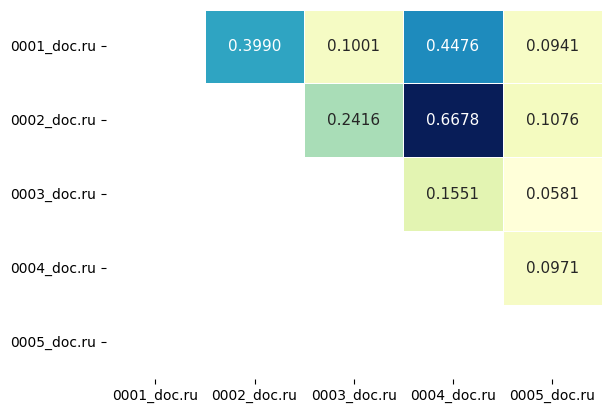

In [17]:
mtx = docs_similarity_df.where(np.triu(np.ones(docs_similarity_df.shape), k=1).astype(np.bool))
sns.heatmap(mtx, cmap='YlGnBu', annot=True, fmt='.4f', linewidths=0.5, annot_kws={'size': 11}, cbar=False);